In [1]:
%cd /mnt/home/zzhang/ceph/CRISPR_pred/crispr_kinn

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import numpy as np
import tensorflow as tf
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0soxsy09 because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
x = np.load('./data/compiled_X.npy')
y = np.load('./data/compiled_Y.npy')
with open('./data/y_col_annot.txt', 'r') as f:
    label_annot = [x.strip() for x in f]
    label_annot = {x:i for i,x in enumerate(label_annot)}
label_annot

{'wtCas9_cleave_rate_log': 0,
 'Cas9_enh_cleave_rate_log': 1,
 'Cas9_hypa_cleave_rate_log': 2,
 'Cas9_HF1_cleave_rate_log': 3,
 'wtCas9_cleave_rate_log_specificity': 4,
 'Cas9_enh_cleave_rate_log_specificity': 5,
 'Cas9_hypa_cleave_rate_log_specificity': 6,
 'Cas9_HF1_cleave_rate_log_specificity': 7,
 'wtCas9_ndABA': 8,
 'Cas9_enh_ndABA': 9,
 'Cas9_hypa_ndABA': 10,
 'Cas9_HF1_ndABA': 11}

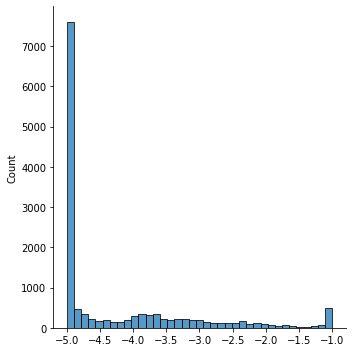

In [4]:
tar_to_train = label_annot['wtCas9_cleave_rate_log']
sns.displot(y[:,tar_to_train])

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=777)

In [6]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(input_shape=(25,13), kernel_size=8, filters=100, padding="same", activation="relu"),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Conv1D(kernel_size=8, filters=50, activation="relu"),
    tf.keras.layers.Dropout(0.1),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="linear")
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 25, 100)           10500     
_________________________________________________________________
dropout (Dropout)            (None, 25, 100)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 18, 50)            40050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 18, 50)            0         
_________________________________________________________________
flatten (Flatten)            (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 901       
Total params: 51,451
Trainable params: 51,451
Non-trainable params: 0
____________________________________________________

In [8]:
model.compile(loss="mse", optimizer="adam")

In [9]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=5,
    verbose=0)

hist = model.fit(x_train,
          y_train[:,tar_to_train],
          batch_size=768,
          callbacks=[checkpointer, earlystopper],
          validation_split=0.1, epochs=500,
          verbose=0)
model.load_weights('bestmodel.h5')

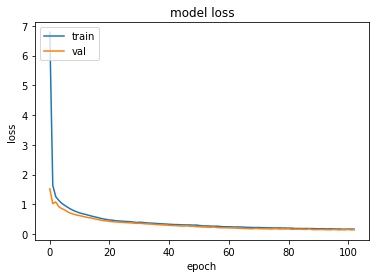

In [10]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

/mnt/home/zzhang/anaconda3/envs/crispr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


spearman SpearmanrResult(correlation=0.8658064354449713, pvalue=0.0)
pearson (0.9486820087529091, 0.0)


Text(0.5, 0.98, 'Testing prediction, pcc=0.949')

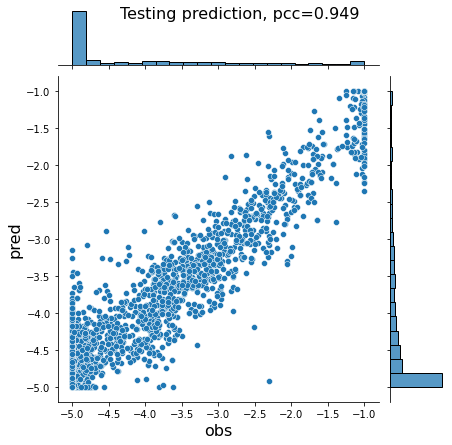

In [11]:
y_hat = model.predict(x_test).flatten()
y_hat = np.clip(y_hat, -5, -1)
h = sns.jointplot(y_test[:,tar_to_train], y_hat)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_hat, y_test[:,tar_to_train]))
p = ss.pearsonr(y_hat, y_test[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Testing prediction, pcc=%.3f"%p[0], fontsize=16)

/mnt/home/zzhang/anaconda3/envs/crispr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


spearman SpearmanrResult(correlation=0.864603096992798, pvalue=0.0)
pearson (0.950985577028814, 0.0)


Text(0.5, 0.98, 'Train fit, pcc=0.951')

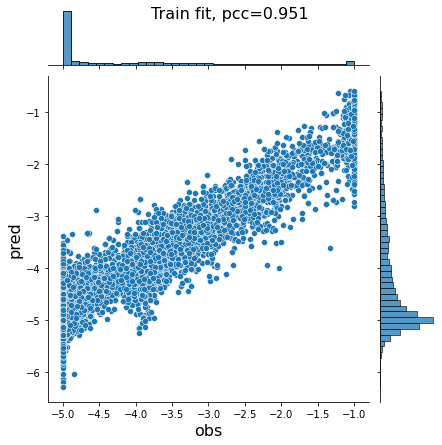

In [12]:
y_fit = model.predict(x_train).flatten()
h = sns.jointplot(y_train[:,tar_to_train], y_fit)
h.set_axis_labels("obs", "pred", fontsize=16)
print("spearman", ss.spearmanr(y_fit, y_train[:,tar_to_train]))
p = ss.pearsonr(y_fit, y_train[:,tar_to_train])
print("pearson", p)
h.fig.suptitle("Train fit, pcc=%.3f"%p[0], fontsize=16)